In [3]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path
from utils.PAD_datamodule import PADDataModule
from model.PAD_convLSTM import ConvLSTM
from utils.settings.config import LINEAR_ENCODER, CLASS_WEIGHTS, BANDS



In [4]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [5]:

# Set seed for everything
pl.seed_everything(42)  # Use a specific seed for reproducibility

# Normalize paths for different OSes
root_path_coco = Path('coco_files/')  # Adjust the path as needed
netcdf_path = Path('dataset/netcdf/')  # Adjust the path as needed

Global seed set to 42


In [6]:

# Create Data Module
dm = PADDataModule(
    netcdf_path=netcdf_path,
    path_train=root_path_coco / '20240220190606_coco_train.json',
    path_val=root_path_coco / '20240220190606_coco_val.json',
    group_freq='1MS',
    bands=['B02', 'B03', 'B04', 'B08'],
    linear_encoder=LINEAR_ENCODER,
    saved_medians=True,
    window_len=6,
    fixed_window=True,
    requires_norm=True,
    return_masks=False,
    clouds=False,
    cirrus=False,
    shadow=False,
    snow=False,
    output_size=(366, 366),
    batch_size=4,
    num_workers=16,
    binary_labels=False,
    return_parcels=False
)

/home/luser/S4A-Models/sentimod/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [7]:
# Model Configuration 
#checkpoint_path = '/home/luser/S4A-Models/logs/convlstm/20240219131342/run_20240219131342/checkpoints/epoch=100-step=1515.ckpt'

checkpoint_path = '/home/luser/S4A-Models/logs/convlstm/20240220235416/run_20240220235416/checkpoints/epoch=100-step=18988.ckpt'

model = ConvLSTM.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda'),  # Adjust device as needed
    run_path=Path('/home/luser/S4A-Models/logs/convlstm/20240220235416/run_20240220235416'),
    linear_encoder=LINEAR_ENCODER,
    crop_encoding=None,  # Add crop_encoding if available
    checkpoint_epoch=100
).to(device)

In [8]:

# Setup for multi-GPUs
dm.setup('fit')
check_data = dm.train_dataloader()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
tensor1 = next(iter(check_data))


model_input = tensor1['medians'].to(device)
expected_output = tensor1['labels'].to(device)


model_output = model(model_input)

In [10]:
model_input.shape, model_output.shape, expected_output.shape

(torch.Size([4, 6, 4, 366, 366]),
 torch.Size([4, 12, 366, 366]),
 torch.Size([4, 366, 366]))

In [11]:
argmax_result = torch.argmax(model_output, dim=1)


In [24]:
model_input[0][0][:3].shape

torch.Size([3, 366, 366])

In [13]:
import numpy as np
import matplotlib.pyplot as plt


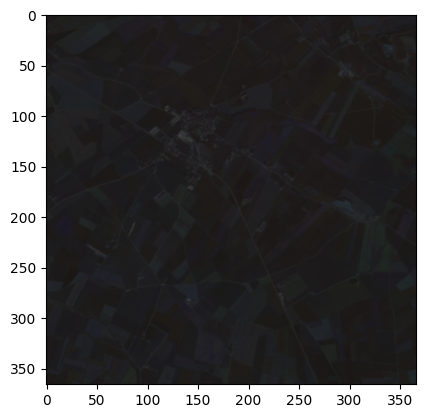

In [27]:
plt.imshow(model_input[0][0][:3].cpu().numpy().transpose(1, 2, 0))

In [28]:
plt.imshow(model_input[0][0].cpu().numpy().transpose(1, 2, 3, 0))

ValueError: axes don't match array

In [14]:
# Get the colored image here
def get_RGB_image(expected_output):
    groud_truth_image = expected_output
    #groud_truth_image_lai = resized_label_space_reset

    color_map = {
        0: [139, 69, 19],      # Brown
        1: [0, 128, 0],         # Green
        2: [192, 192, 192],      # Silver
        3: [0, 0, 255],          # Blue
        4: [255, 255, 0],        # Yellow
        5: [255, 165, 0],        # Orange
        6: [255, 0, 255],        # Magenta
        7: [0, 255, 255],        # Cyan
        8: [128, 0, 128],        # Violet
        9: [128, 128, 0],        # Olive
        10: [0, 128, 0],         # Dark Green
        11: [128, 0, 0],         # Maroon
        12: [0, 0, 128],         # Navy
        13: [128, 128, 128],     # Gray
        14: [255, 0, 0]
        } 


    # Create color plot
    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    #groud_truth_color_image_lai = np.zeros(groud_truth_image_lai.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            #segment_id_gt_lai = groud_truth_image_lai[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt.item()]
            #groud_truth_color_image_lai[i, j] = color_map[segment_id_gt_lai]
    return groud_truth_color_image

In [15]:
groud_truth_color_image = get_RGB_image(expected_output[1])



In [26]:
groud_truth_color_image.shape

(366, 366, 3)

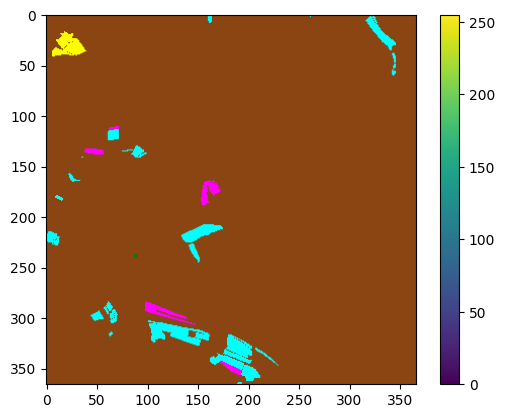

In [16]:
# plot the color image
plt.imshow(groud_truth_color_image)
plt.colorbar()

In [17]:
expected_output_rgb = []
expected_output_model = []


for i in range(len(expected_output)):
    rgb_image_expected = get_RGB_image(expected_output[i])
    rgb_image_model_out = get_RGB_image(argmax_result[i])
    #print(rgb_image.shape)
    #print("torch.tensor(rgb_image).unsqueeze(0)", torch.tensor(rgb_image).unsqueeze(0).shape)
    expected_output_rgb.append(rgb_image_expected)
    expected_output_model.append(rgb_image_model_out)
        


In [18]:
len(expected_output_rgb)

4

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
    fig = plt.figure(figsize=(10,10))
    for i in range(1):
        plt.subplot(1, 1,i+1)
        plt.imshow(expected_output_rgb[i])
        plt.axis('off')
    plt.show()

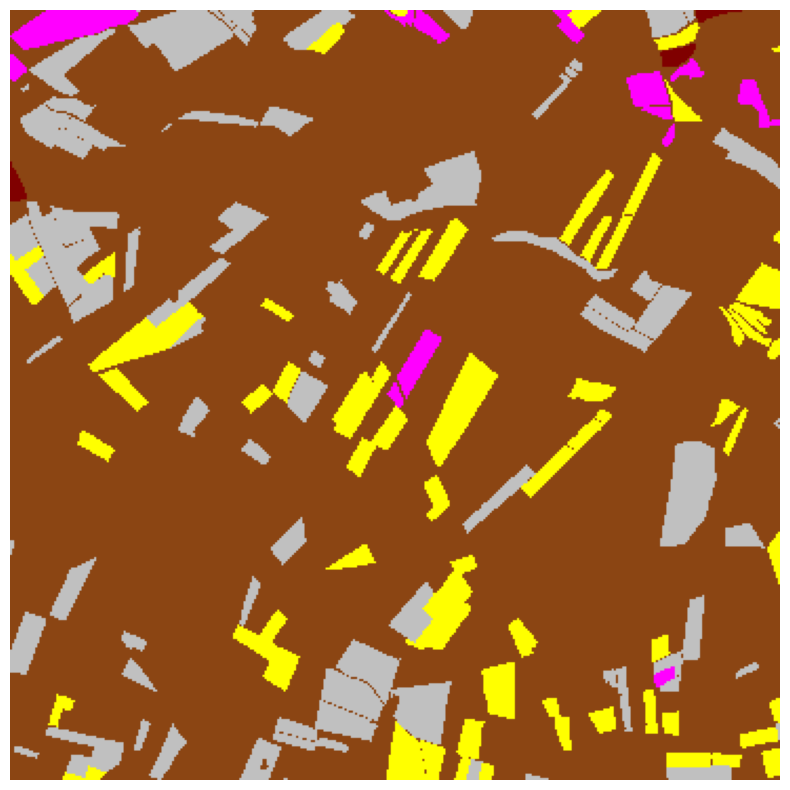

In [21]:
import matplotlib.pyplot as plt
with torch.no_grad():
    fig = plt.figure(figsize=(10,10))
    for i in range(1):
        plt.subplot(1, 1,i+1)
        plt.imshow(expected_output_rgb[i])
        plt.axis('off')
    plt.show()

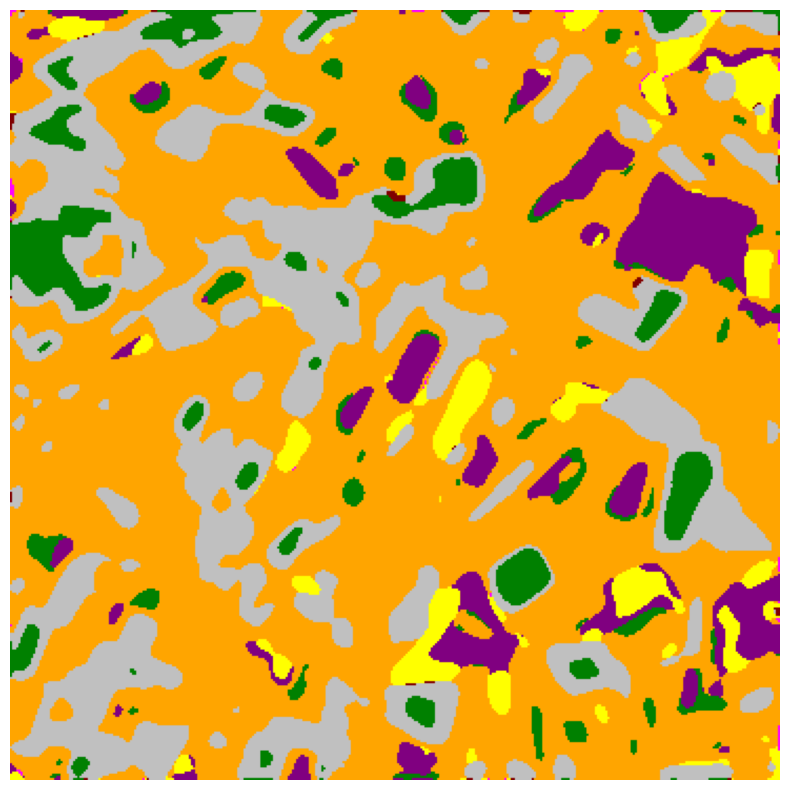

In [22]:
import matplotlib.pyplot as plt
with torch.no_grad():
    fig = plt.figure(figsize=(10,10))
    for i in range(1):
        plt.subplot(1, 1,i+1)
        plt.imshow(expected_output_model[i])
        plt.axis('off')
    plt.show()

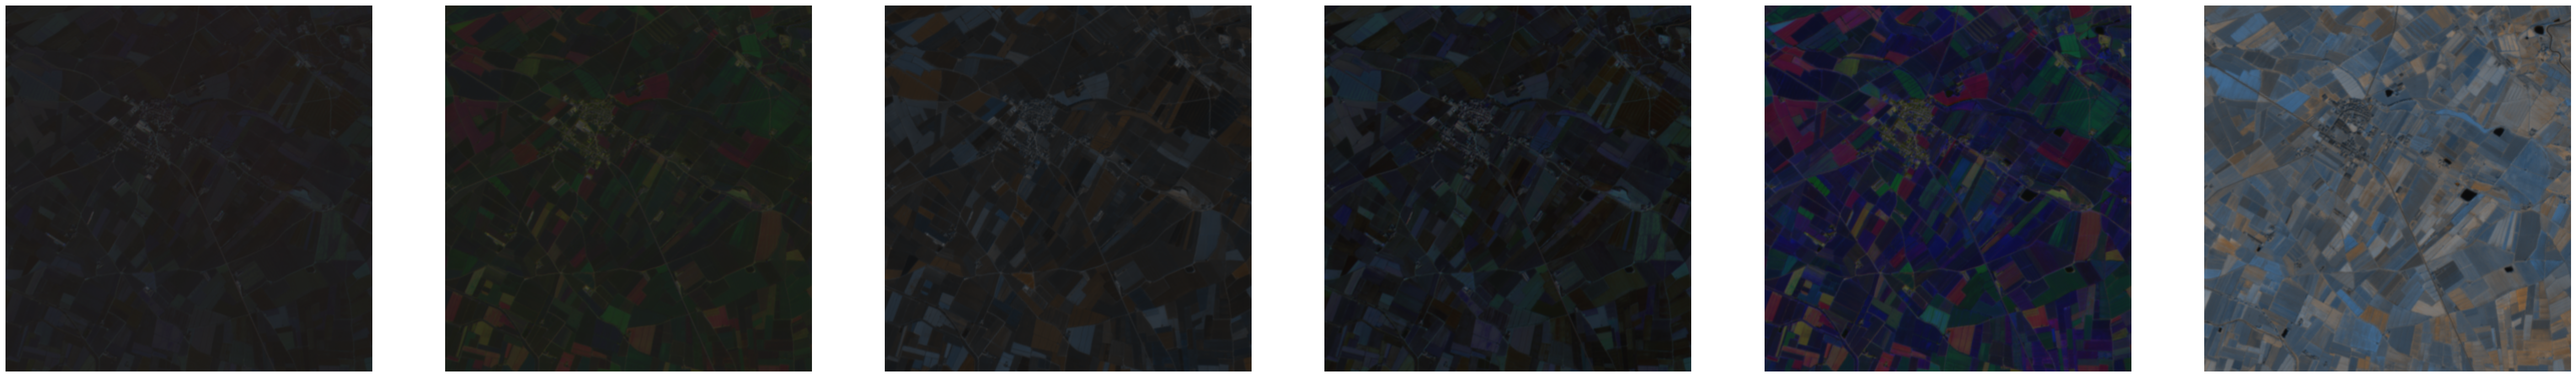

In [36]:
import matplotlib.pyplot as plt
with torch.no_grad():
    fig = plt.figure(figsize=(60,60))
    for i in range(6):
        plt.subplot(1, 6,i+1)
        plt.imshow(model_input[0][i][:3].cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.savefig('input_images.png')
    plt.show()